# Individual Playwrights in the Context of The Evolution of The French Comedy
In this analysis we will explore the playwrights in the context of the evolution of the five-act comedy in verse. We will focus on the following features:
- The number of dramatic characters
- The mobility coefficient
- The standard range of the number of speaking characters
- The percentage of polylogues
- The percentage of monologues.

Our agenda:
1. For each time period and each feature, we will identify the comedy that that represents the maximum, the minimum, and the comedies that are the closest to the mean.
2. For each time period, we create a summary for individual playwrights that represent two groups (more prolific, i.e., those who wrote at least two five-act verse comedies, and less prolific, i.e., those who wrote only one such comedy).
    - Calculate the mean number of dramatic characters, mean mobility coefficient, the standard range of the number of speaking characters (sigma), the mean percentage of polylogues, and the mean percentage of monologues.
    - Calculate open-form scores for each playwright that tell us how experimental each playwright is.
3. Examine the evolution of Fabre d'Églantine and Jean-François Collin d’Harleville whose oeuvre spanned two literary periods.

### Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import re
import joblib

### Define Functions

In [2]:
# update the boundaries as we determined based on our hypothesis testing
def determine_period(row):
    if row <= 1695:
        period = 1
    elif row >= 1696 and row <= 1795:
        period = 2
    else:
        period = 3
    
    return period

In [3]:
def make_list(row):
    speech_dist = []
    for value in row[1:-1].split('\n '):
        speech_dist.append([int(num) for num in re.findall('[0-9]+', value)])
        
    return speech_dist

In [4]:
def speech_distribution_by_period(period_df):
    all_distributions = []
    for row in period_df['speech_distribution']:
        speech_dist_df = pd.DataFrame(row).T
        # rename columns to make sure they start with 1 and not 0
        speech_dist_df.columns = speech_dist_df.iloc[0, :]
        # no need to include the variants as a row - they will be column names
        only_counts_df = pd.DataFrame(speech_dist_df.iloc[1, :])
        only_counts_df.columns = ['raw_numbers']
        only_counts_df['percentage'] = only_counts_df['raw_numbers'] / only_counts_df.sum().values[0]
        all_distributions.append(round(only_counts_df['percentage'], 4))
    period_df_dist = pd.concat(all_distributions, axis=1).fillna(0)
    # take the mean for each period
    mean_per_type = pd.DataFrame(period_df_dist.mean(axis=1)).T 
    mean_per_type.index.name = 'number_of_speakers'
    mean_per_type = (mean_per_type * 100).round(2)
        
    return mean_per_type

In [5]:
def sigma_iarkho(df):
    """
    The function allows calculating standard range following iarkho's procedure.
    Parameters:
        df  - a dataframe where columns are variants, i.e., the distinct number of speakers in the ascending order, 
              e.g. [1, 2, 3, 4, 5] and values weights corresponding to these variants, i.e.,
              the number of scenes, e.g. [20, 32, 18, 9, 1]
    Returns:
        sigma - standard range per iarkho
    """
    weighted_mean_variants = np.average(df.columns.tolist(), weights=df.values[0])
    differences_squared = [(variant - weighted_mean_variants)**2 for variant in df.columns]
    weighted_mean_difference = np.average(differences_squared, weights=df.values[0])
    sigma = round(weighted_mean_difference**0.5, 2)

    return sigma

In [6]:
def sigma_for_playwrights(df, playwrights_lst):
    sigmas = []
    for playwright in playwrights_lst:
        selection = df[(df.last_name == playwright[0]) & (df.first_name == playwright[1])].copy()
        sigma = selection.pipe(speech_distribution_by_period).pipe(sigma_iarkho)
        sigmas.append(sigma)
        
    summary = pd.DataFrame(sigmas, columns=['sigma_iarkho'])
    summary['z_score'] = (summary['sigma_iarkho'] - df['sigma_iarkho'].mean()) / df['sigma_iarkho'].std()
    summary.index = playwrights_lst
    
    return summary

In [7]:
def summary_feature(df, feature):
    print('Mean, standard deviation, median, min and max values for the period:')
    display(df[feature].describe()[['mean', 'std', '50%','min', 'max']].round(2))
    print('Period Max:')
    display(df[df[feature] == df[feature].max()][['last_name', 'first_name', 'title', 'date', feature]].round(2))
    print('Period Min:')
    display(df[df[feature] == df[feature].min()][['last_name', 'first_name', 'title', 'date', feature]].round(2))
    print('The closest to the mean:')
    df_copy = df.copy()
    df_copy['diff_with_mean'] = df_copy[feature].apply(lambda x: np.absolute(x - df_copy[feature].mean()))
    display(df_copy[df_copy['diff_with_mean'] == df_copy['diff_with_mean'].min()][['last_name', 'first_name', 'title', 'date', feature]].round(2))

In [8]:
def authors_data(data_df, feature):
    overall_mean = round(data_df[feature].mean(), 2)
    overall_std = round(data_df[feature].std(), 2)
    statistics = ['mean'] 
    all_authors = pd.DataFrame(data_df.groupby(['last_name', 'first_name'])[feature].mean())
    all_authors.columns= ['mean']
    all_authors['z_score'] = (all_authors['mean'] - overall_mean) / overall_std
    
    return  all_authors

In [9]:
def playwrights_place(df, with_z_score=True):
    if with_z_score:
        column = 'z_score'
        sigma_col = column
    else:
        column = ['mean']
        sigma_col = 'sigma_iarkho'
    summary = pd.DataFrame(authors_data(df, 'num_present_characters')[column])
    summary.columns = ['num_present_characters']
    # make sure the order of the playwrights is the same
    
    ind = summary.index
    summary['mobility_coefficient'] = authors_data(df, 'mobility_coefficient', 
                                                        ).loc[ind, column]
    summary['sigma_iarkho'] = sigma_for_playwrights(df, ind)[sigma_col]
    summary['polylogues'] = authors_data(df, 'percentage_polylogues', 
                                                         ).loc[ind, column]
    summary['monologues'] = authors_data(df, 'percentage_monologues', 
                                                         ).loc[ind, column]
    summary = summary.round(2)
    if with_z_score:
        summary['monologues'] = summary['monologues'].apply(lambda x: -x)
        summary['open_form_score'] = round(summary.apply(lambda x: x.mean(), axis=1), 2)
        summary = summary.sort_values(by='open_form_score', ascending=False)
        
    return summary

### Load Data

In [10]:
data = pd.read_csv('../French_Comedies/Data/French_Comedies_Data.csv')

In [11]:
data.shape

(277, 25)

In [12]:
# include only five act comedies and only original comedies
original_comedies = data[(data['num_acts'] ==5)&
                         (data['translation/adaptation/contrastive'] == 0)].copy()

In [13]:
original_comedies.head(3)

,index,title,last_name,first_name,date,translation/adaptation/contrastive,num_acts,url,num_present_characters,num_scenes_text,...,percentage_above_two_speakers,av_percentage_non_speakers,sigma_iarkho,number_scenes_with_discontinuous_change_characters,percentage_scenes_with_discontinuous_change_characters,total_utterances,num_verse_lines,dialogue_vivacity,five_year_intervals,decades
0,F_3,Mélite ou Les fausses lettres,Corneille,Pierre,1629,0,5,http://www.theatre-classique.fr/pages/document...,8,35,...,23.08,0.513,0.906,12,30.769,483.0,1822.0,0.265,1630,1630
1,F_5,La Veuve ou Le Traître trahi,Corneille,Pierre,1633,0,5,http://www.theatre-classique.fr/pages/document...,12,40,...,20.00,3.519,1.062,12,26.667,521.0,2010.0,0.259,1635,1640
2,F_9,La Célimène,Rotrou,Jean de,1633,0,5,http://www.xn--thtre-documentation-cvb0m.com/c...,10,36,...,22.22,8.963,1.092,5,11.111,NaN,NaN,NaN,1635,1640


In [14]:
original_comedies.shape

(257, 25)

In [15]:
sorted_comedies = original_comedies.sort_values(by='date')

In [16]:
sorted_comedies['period'] = sorted_comedies['date'].apply(determine_period)

In [17]:
sorted_comedies = sorted_comedies.rename(columns={'num_scenes_iarkho': 'mobility_coefficient', 
                                                  'percentage_non_duologues': 'percentage_non_dialogues',
                                                  'percentage_above_two_speakers': 'percentage_polylogues'})

In [18]:
# remove white spaces
sorted_comedies['last_name'] = sorted_comedies['last_name'].str.strip()
sorted_comedies['first_name'] = sorted_comedies['first_name'].str.strip()
sorted_comedies['first_name'] = sorted_comedies['first_name'].fillna('')
sorted_comedies['speech_distribution'] = sorted_comedies['speech_distribution'].apply(make_list)

In [19]:
period_one = sorted_comedies[sorted_comedies.period == 1].copy()
period_two = sorted_comedies[sorted_comedies.period == 2].copy()
period_three = sorted_comedies[sorted_comedies.period == 3].copy()

## Part 1. The Maximum, The Minimum, and The Closest to The Mean

### Period 1 (1629 to 1695)

#### Number of Dramatic Characters

In [20]:
summary_feature(period_one, 'num_present_characters')

Mean, standard deviation, median, min and max values for the period:


mean    11.91
std      4.05
50%     11.00
min      7.00
max     30.00
Name: num_present_characters, dtype: float64

Period Max:


,last_name,first_name,title,date,num_present_characters
78,Chalussay,Le Boulanger de,Elomire Hypocondre,1670,30


Period Min:


,last_name,first_name,title,date,num_present_characters
23,Corneille,Pierre,La Suite du menteur,1643,7
68,Montfleury,,L’École des filles,1666,7
79,Marcel,,Le Mariage sans mariage,1671,7


The closest to the mean:


,last_name,first_name,title,date,num_present_characters
1,Corneille,Pierre,La Veuve ou Le Traître trahi,1633,12
4,Corneille,Pierre,La Galerie du Palais,1634,12
52,Boisrobert,François Le Métel de,Les Apparences trompeuses,1655,12
58,Molière,,Le Dépit amoureux,1658,12
63,Montfleury,,Le Mari sans femme,1663,12
64,Boursault,Edmé,Les Nicandres,1663,12
66,Boursault,Edmé,Les deux frères gémeaux,1665,12
77,Poisson,Raymond,Les Pipeurs ou les Femmes coquettes,1670,12


#### Mobility Coefficient

In [21]:
summary_feature(period_one, 'mobility_coefficient')

Mean, standard deviation, median, min and max values for the period:


mean    41.9
std     11.6
50%     40.0
min     19.0
max     85.0
Name: mobility_coefficient, dtype: float64

Period Max:


,last_name,first_name,title,date,mobility_coefficient
84,Hauteroche,"Noël Lebreton, sieur de",Crispin musicien,1674,85


Period Min:


,last_name,first_name,title,date,mobility_coefficient
16,Guérin de Bouscal,Guyon,Dom Quixote de la Manche,1639,19


The closest to the mean:


,last_name,first_name,title,date,mobility_coefficient
37,Boisrobert,François Le Métel de,La Folle Gageure,1651,42
43,Corneille,Thomas,Le Charme de la voix,1653,42
77,Poisson,Raymond,Les Pipeurs ou les Femmes coquettes,1670,42


#### Standard Range of the Number of Speaking Characters (Sigma)

In [22]:
summary_feature(period_one, 'sigma_iarkho')

Mean, standard deviation, median, min and max values for the period:


mean    1.25
std     0.40
50%     1.19
min     0.60
max     3.54
Name: sigma_iarkho, dtype: float64

Period Max:


,last_name,first_name,title,date,sigma_iarkho
78,Chalussay,Le Boulanger de,Elomire Hypocondre,1670,3.54


Period Min:


,last_name,first_name,title,date,sigma_iarkho
67,Quinault,Philippe,La Mère coquette,1665,0.6


The closest to the mean:


,last_name,first_name,title,date,sigma_iarkho
87,Montfleury,,Crispin gentilhomme,1677,1.25


#### The Percentage of Polylogues

In [23]:
summary_feature(period_one, 'percentage_polylogues')

Mean, standard deviation, median, min and max values for the period:


mean    42.36
std     13.87
50%     41.46
min     10.64
max     86.21
Name: percentage_polylogues, dtype: float64

Period Max:


,last_name,first_name,title,date,percentage_polylogues
39,Boisrobert,François Le Métel de,Les trois Orontes,1652,86.21


Period Min:


,last_name,first_name,title,date,percentage_polylogues
5,Corneille,Pierre,La Suivante,1634,10.64


The closest to the mean:


,last_name,first_name,title,date,percentage_polylogues
24,Ouville,Antoine d',La Dame suivante,1643,42.31


#### The Percentage of Monologues

In [24]:
summary_feature(period_one, 'percentage_monologues')

Mean, standard deviation, median, min and max values for the period:


mean    13.41
std      9.55
50%     12.12
min      0.00
max     33.33
Name: percentage_monologues, dtype: float64

Period Max:


,last_name,first_name,title,date,percentage_monologues
2,Rotrou,Jean de,La Célimène,1633,33.33


Period Min:


,last_name,first_name,title,date,percentage_monologues
16,Guérin de Bouscal,Guyon,Dom Quixote de la Manche,1639,0.0
33,Scarron,Paul,L'Héritier ridicule ou la Dame intéressée,1649,0.0
40,Scarron,Paul,Don Japhet d'Arménie,1652,0.0
44,Boisrobert,François Le Métel de,La Belle plaideuse,1654,0.0
59,Corneille,Thomas,Le Galant doublé,1660,0.0
67,Quinault,Philippe,La Mère coquette,1665,0.0
69,Molière,,Le Misanthrope,1666,0.0
71,Corneille,Thomas,Le Baron d'Albikrac,1668,0.0
75,Corneille,Thomas,La Comtesse d'Orgueil,1670,0.0


The closest to the mean:


,last_name,first_name,title,date,percentage_monologues
17,Mareschal,André,Le Véritable Capitan Matamore,1640,13.33


## Period 2 (1696 to 1795)

#### Number of Dramatic Characters

In [25]:
summary_feature(period_two, 'num_present_characters')

Mean, standard deviation, median, min and max values for the period:


mean    10.53
std      2.89
50%     10.00
min      6.00
max     24.00
Name: num_present_characters, dtype: float64

Period Max:


,last_name,first_name,title,date,num_present_characters
199,Cubières-Palmézeaux,Michel de,L'Homme d'état imaginaire,1789,24


Period Min:


,last_name,first_name,title,date,num_present_characters
156,Néricault Destouches,,Le Mari confident,1758,6
161,Bastide,Jean-François de,Le Jeune homme,1766,6


The closest to the mean:


,last_name,first_name,title,date,num_present_characters
104,Dancourt,,Les Enfants de Paris ou la Famille à la mode,1699,11
124,Néricault Destouches,,Les Philosophes amoureux,1729,11
126,Du Fresny,Charles,Le Faux Sincère,1731,11
130,Rousseau,Jean-Baptiste,Les ayeux chimériques ou la comtesse de Critognac,1735,11
136,Néricault Destouches,,L'Ambitieux et l'Indiscrète,1737,11
185,Bièvre,Marquis de,Le Séducteur,1783,11
190,Borel,,Le Méfiant,1786,11
195,Collin d’Harleville,Jean-François,L'Optimiste ou l'Homme content de tout,1788,11
200,Fabre d'Églantine,,Le Philinte de Molière,1790,11


#### Mobility Coefficient

In [26]:
summary_feature(period_two, 'mobility_coefficient')

Mean, standard deviation, median, min and max values for the period:


mean    49.29
std     11.32
50%     48.50
min     29.00
max     91.00
Name: mobility_coefficient, dtype: float64

Period Max:


,last_name,first_name,title,date,mobility_coefficient
162,Chauveau,,L'homme de cour,1767,91


Period Min:


,last_name,first_name,title,date,mobility_coefficient
140,Nivelle de la Chaussée,Pierre Claude,Mélanide,1741,29


The closest to the mean:


,last_name,first_name,title,date,mobility_coefficient
102,Rousseau,Jean-Baptiste,Le Flatteur,1696,49
111,Regnard,Jean-François,Le Légataire Universel,1708,49
122,Néricault Destouches,,Le Philosophe marié,1727,49
138,Boissy,Louis de,Les Dehors trompeurs,1740,49
146,Voltaire,,La Prude,1747,49
154,La Noue,Jean-Baptiste,La Coquette corrigée,1757,49
171,Bret,Antoine,Le protecteur bourgeois ou la confiance trahie,1772,49
207,Reynier,L.,L'Avare fastueux,1794,49


#### Sigma

In [27]:
summary_feature(period_two, 'sigma_iarkho')

Mean, standard deviation, median, min and max values for the period:


mean    1.12
std     0.29
50%     1.10
min     0.63
max     1.98
Name: sigma_iarkho, dtype: float64

Period Max:


,last_name,first_name,title,date,sigma_iarkho
152,Rousseau,Jean-Baptiste,La Femme qui ne parle point ou l'hypocondre,1751,1.98


Period Min:


,last_name,first_name,title,date,sigma_iarkho
177,Dorat,Claude-Joseph,Roséïde ou l'Intrigant,1779,0.63


The closest to the mean:


,last_name,first_name,title,date,sigma_iarkho
118,Néricault Destouches,,Le Médisant,1715,1.12


#### The Percentage of Polylogues

In [28]:
summary_feature(period_two, 'percentage_polylogues')

Mean, standard deviation, median, min and max values for the period:


mean    31.62
std     11.03
50%     31.50
min      8.70
max     58.06
Name: percentage_polylogues, dtype: float64

Period Max:


,last_name,first_name,title,date,percentage_polylogues
130,Rousseau,Jean-Baptiste,Les ayeux chimériques ou la comtesse de Critognac,1735,58.06


Period Min:


,last_name,first_name,title,date,percentage_polylogues
178,Delon,,"Le Financier, comédie en cinq actes et en vers",1779,8.7


The closest to the mean:


,last_name,first_name,title,date,percentage_polylogues
105,Regnard,Jean-François,Démocrite amoureux,1700,31.58


#### The Percentage of Monologues

In [29]:
summary_feature(period_two, 'percentage_monologues')

Mean, standard deviation, median, min and max values for the period:


mean    22.08
std      7.75
50%     21.88
min      3.23
max     40.48
Name: percentage_monologues, dtype: float64

Period Max:


,last_name,first_name,title,date,percentage_monologues
161,Bastide,Jean-François de,Le Jeune homme,1766,40.48


Period Min:


,last_name,first_name,title,date,percentage_monologues
130,Rousseau,Jean-Baptiste,Les ayeux chimériques ou la comtesse de Critognac,1735,3.23


The closest to the mean:


,last_name,first_name,title,date,percentage_monologues
205,Collin d’Harleville,Jean-François,Le Vieux célibataire,1792,22.03


### Period 3 (1796 to 1849)

#### Number of Dramatic Characters

In [30]:
summary_feature(period_three, 'num_present_characters')

Mean, standard deviation, median, min and max values for the period:


mean    12.11
std      4.28
50%     11.00
min      6.00
max     28.00
Name: num_present_characters, dtype: float64

Period Max:


,last_name,first_name,title,date,num_present_characters
257,Gosse,Étienne,"Les Jésuites, ou les autres Tartuffes",1827,28


Period Min:


,last_name,first_name,title,date,num_present_characters
276,Augier,Émile,Gabrielle,1849,6


The closest to the mean:


,last_name,first_name,title,date,num_present_characters
213,Fabre d'Églantine,,Les Précepteurs,1799,12
226,Étienne,Charles-Guillaume,Les Deux gendres,1810,12
240,Théaulon,Emmanuel,"L'Artiste ambitieux, ou l'Adoption",1820,12
248,Bonjour,Casimir,L’Éducation ou les deux Cousine,1823,12
256,Bonjour,Casimir,L’Argent ou les Moeurs du Jour,1826,12


#### Mobility Coefficient

In [31]:
summary_feature(period_three, 'mobility_coefficient')

Mean, standard deviation, median, min and max values for the period:


mean    54.58
std      9.99
50%     53.50
min     34.00
max     86.00
Name: mobility_coefficient, dtype: float64

Period Max:


,last_name,first_name,title,date,mobility_coefficient
257,Gosse,Étienne,"Les Jésuites, ou les autres Tartuffes",1827,86


Period Min:


,last_name,first_name,title,date,mobility_coefficient
238,Duval,Alexandre,Le Chevalier d'industrie,1818,34


The closest to the mean:


,last_name,first_name,title,date,mobility_coefficient
225,Picard,Louis-Benoît,Les Capitulations de conscience,1809,55
243,Delavigne,Casimir,Les Comédiens,1820,55


#### Sigma

In [32]:
summary_feature(period_three, 'sigma_iarkho')

Mean, standard deviation, median, min and max values for the period:


mean    1.33
std     0.32
50%     1.26
min     0.84
max     2.54
Name: sigma_iarkho, dtype: float64

Period Max:


,last_name,first_name,title,date,sigma_iarkho
260,Delavigne,Casimir,La Princesse Aurélie,1828,2.54


Period Min:


,last_name,first_name,title,date,sigma_iarkho
239,Michaud,L. G.,"Le Faux ami de cour, ou le Danger des liaisons",1818,0.84


The closest to the mean:


,last_name,first_name,title,date,sigma_iarkho
273,Rey,Charles,La séduction et l'amour vrai,1847,1.33


#### The Percentage of Polylogues

In [33]:
summary_feature(period_three, 'percentage_polylogues')

Mean, standard deviation, median, min and max values for the period:


mean    38.09
std      8.70
50%     37.31
min     18.46
max     65.00
Name: percentage_polylogues, dtype: float64

Period Max:


,last_name,first_name,title,date,percentage_polylogues
237,Merville,,"La Famille Glinet, ou Les premiers temps de la...",1818,65.0


Period Min:


,last_name,first_name,title,date,percentage_polylogues
250,Bonjour,Casimir,"Le Mari à bonnes fortunes, ou La Leçon",1824,18.46


The closest to the mean:


,last_name,first_name,title,date,percentage_polylogues
256,Bonjour,Casimir,L’Argent ou les Moeurs du Jour,1826,37.88


#### The Percentage of Monologues

In [34]:
summary_feature(period_three, 'percentage_monologues')

Mean, standard deviation, median, min and max values for the period:


mean    20.08
std      5.95
50%     18.94
min     11.36
max     43.08
Name: percentage_monologues, dtype: float64

Period Max:


,last_name,first_name,title,date,percentage_monologues
250,Bonjour,Casimir,"Le Mari à bonnes fortunes, ou La Leçon",1824,43.08


Period Min:


,last_name,first_name,title,date,percentage_monologues
276,Augier,Émile,Gabrielle,1849,11.36


The closest to the mean:


,last_name,first_name,title,date,percentage_monologues
242,Gosse,Étienne,Le Flatteur,1820,20.0


### Summary

The maximum for all features:
- The number of dramatic characters: 30 in period one (Chalussay’s *Elomire Hypocondre* (1670)), 24 in period two (Cubières-Palmézeaux’s *L'Homme d'état imaginaire* (1789)), 28 in  period three Gosse’s *Les Jésuites, ou les autres Tartuffes* (1827)).

- The mobility coefficient: 85 in period one (Hauteroche’s *Crispin musician* (1674)) , 91 in period two (Chauveau’s *L’homme de cour* (1767)), 86  in period three (Gosse’s *Les Jésuites, ou les autres Tartuffes* (1827)).

- The standard range of the number of speaking characters (sigma): 3.54  in period one (Chalussay’s *Elomire Hypocondre* (1670)), 1.98 in period two (Rousseau’s *La Femme qui ne parle point ou l’hypocondre* (1751)), 2.54 in period three: (Delavigne’s *La Princesse Aurélie* (1828)).

- The Percentage of polylogues: 86.21% in period one (Boisrobert’s *Les trois Orontes* (1652)), 58.06% in period two (Rousseau’s *Les ayeux chimériques ou la comtesse de Critognac* (1735), 65.0% in period three: Merville’s *La Famille Glinet* (1818)).

- The Percentage of monologues: 33.33% in period one: (Rotrou’s *La Célimène* (1633), 40.48% in period two (Bastide’s *Le Jeune homme* (1766)), 43.08% in period three (Bonjour’s *Le Mari à bonnes fortunes, ou La Leçon* (1824)).
    
   Three authors (Chalussay, Rousseau, and Gosse) wrote the comedies that represent the maximum for their period based on at least two features.
   
The minimum for all features:   
- The number of dramatic characters: 7 in period one: (three comedies including Pierre Corneille’s *La Suite du menteur* (1643)),  Montfleury’s *L’École des filles* (1666), and Marcel’s *Le Mariage sans marriage* (1671), 6 in period two period (Destouches’s *Le Mari confident* (1758) and Bastide’s *Le Jeune homme* (1766)), 6 in period three (Augier’s *Gabrielle* (1849)).

- The mobility coefficient: 19 in period one: (Guérin de Bouscal’s *Dom Quixote de la Manche* (1639)), 29 in period two: (Nivelle de la Chaussée’s *Mélanide* (1741), 34 in period three: Duval’s *Le Chevalier d’industrie* (1818))

- The standard range of the number of speaking characters (sigma):  0.6 in period one: (Quinault’s *La Mère coquette* (1665)), 0.63 in period two: (Dorat’s *Roséïde ou l’Intrigant* (1779)), 0.84 in period three: (Michaud’s *Le Faux ami de cour, ou le Danger des liaisons* (1818)).

- The percentage of polylogues: 10.64% in period one (Pierre Corneille’s *La Suivante* (1634)), 8.7% in period two (Delon’s *Le Financier* (1779)), 18.46% in period three: (Bonjour’s *Le Mari à bonnes fortunes, ou La Leçon*  (1824)).

- The percentage of monologues: 0% in nine comedies in period one: period one, including Guyon’s *Dom Quixote de la Manche* (1639), Scarron’s *L’Héritier ridicule ou la Dame intéressée* (1649) and *Don Japhet d’Arménie* (1652), Boisrobert’s *La Belle plaideuse* (1654), Thomas Corneille’s *Le Galant double* (1660), *Le Baron d’Albikrac* (1668), and *La Comtesse d’Orgueil* (1670), Quinault’s *La Mère coquette* (1665), and Molière’s *Le Misanthrope* (1666); 3.23% in period two (Rousseau’s *Les ayeux chimériques ou la comtesse de Critognac*), 11.36% in period three: (Augier’s *Gabrielle*).
    
    
    One author, Pierre Corneille, wrote comedies that represented period minimum based on at least two features (the number of dramatic characters and the percentage of polylogues).

## Part 2. Summary For Individual Playwrights

It is important to be able to place each author's comedic style in the context of the entire history of the French five-act comedy in verse. In order to do this, we calculate the mean number of dramatic characters, mean mobility coefficient, the standard range of the number of speaking characters (sigma), the mean percentage of polylogues, and the mean percentage of monologues. We quanitify how much a playwright prefers to write comedies with more open forms based on all features.

#### Open Form Scores:
1. For all features, we will calculate **the z-score**: $z=(x-u)/s$ where u is the mean of the feature and s is the standard deviation of this feature. For the percentage of monologues, we will reverse the sign, i.e., will use **- z-score** since it is the lower value of the percentage of monologues that indicates a more open form.
3. The **open form score** will be the mean z-score. For example, if Boisrobert has the following z-scores (0.48, -0.86,  0.60,  1.45) and -z-score for the percentage of monologues of 1.68, his **open form score** = (0.48 -0.86 + 0.60 + 1.45 + 1.68) / 5 ≈ 0.67. The open form scores can be positive and negative, where high positive number indicates the most open form, whereas the high negative number indicates the least open form.

## More and Less Prolific Playwrights

We will define the playwrights who wrote at least two five-act comedies in verse as prolific and those who wrote a single five-act verse comedy as less prolific. We will explore how many representatives are in each group and examine if open-form scores differ in those two groups by period.

In [35]:
def authors_by_output(df):
    counts = df.groupby(['last_name', 'first_name']).count()['index']
    playwrights_over_one = counts[counts > 1].index
    playwrights_one = counts[counts == 1].index
    
    return playwrights_over_one, playwrights_one

In [36]:
# remove co-authored comedies
no_co_authored = sorted_comedies[sorted_comedies.last_name.str.count(';') == 0].copy()

In [37]:
results = playwrights_place(no_co_authored, with_z_score=True)

In [38]:
over_one, only_one = authors_by_output(no_co_authored)

In [39]:
sorted_above_one = results.loc[over_one, :].sort_values(by='open_form_score', ascending=False)

#### Prolific

In [40]:
print('Number of more prolific playwrigthts:', 
sorted_above_one.shape[0])

Number of more prolific playwrigthts: 41


#### Less Prolific

In [41]:
sorted_only_one = results.loc[only_one, :].sort_values(by='open_form_score', ascending=False)

In [42]:
print('Number of less prolific playwrigthts:', 
sorted_only_one.shape[0])

Number of less prolific playwrigthts: 80


## Period One: Z-Scores and Open-Form Scores

### Prolific

In [43]:
sorted_above_one_play_period_one = sorted_above_one.loc[period_one.last_name.unique(), :]

In [44]:
sorted_above_one_play_period_one

,,num_present_characters,mobility_coefficient,sigma_iarkho,polylogues,monologues,open_form_score
last_name,first_name,,,,,,
Hauteroche,"Noël Lebreton, sieur de",0.64,1.51,0.40,0.88,0.64,0.81
Boisrobert,François Le Métel de,0.48,-0.86,0.60,1.45,1.68,0.67
La Fontaine,Jean de,2.05,0.09,1.12,0.11,-0.43,0.59
Gillet de la Tessonnerie,N.,0.61,-1.25,0.80,1.26,1.06,0.50
Ouville,Antoine d',-0.28,0.31,0.23,0.76,1.15,0.43
Corneille,Thomas,-0.03,-0.48,-0.23,1.18,1.43,0.37
Scarron,Paul,0.03,-0.69,0.75,0.61,0.55,0.25
Boursault,Edmé,1.24,-0.26,-0.06,0.06,0.28,0.25
Molière,,-0.06,-1.26,0.60,0.00,0.83,0.02


In [45]:
print('The percentage of playwrigthts writing comedies with the open form: {}%'.format( 
round((sorted_above_one_play_period_one[sorted_above_one_play_period_one.open_form_score >= 0].shape[0] /
      sorted_above_one_play_period_one.shape[0]) * 100, 2)))

The percentage of playwrigthts writing comedies with the open form: 71.43%


In [46]:
print('The percentage of playwrigthts writing comedies with the closed form: {}%'.format(
round((sorted_above_one_play_period_one[sorted_above_one_play_period_one.open_form_score < 0].shape[0]/
      sorted_above_one_play_period_one.shape[0]) * 100, 2)))

The percentage of playwrigthts writing comedies with the closed form: 28.57%


### Less Prolific

In [47]:
sorted_comedies[sorted_comedies.last_name=='Chalussay']

,index,title,last_name,first_name,date,translation/adaptation/contrastive,num_acts,url,num_present_characters,num_scenes_text,...,av_percentage_non_speakers,sigma_iarkho,number_scenes_with_discontinuous_change_characters,percentage_scenes_with_discontinuous_change_characters,total_utterances,num_verse_lines,dialogue_vivacity,five_year_intervals,decades,period
78,F_78,Elomire Hypocondre,Chalussay,Le Boulanger de,1670,0,5,http://www.theatre-classique.fr/pages/document...,30,15,...,26.764,3.543,3,15.0,533.0,1770.0,0.301,1670,1670,1


In [48]:
sorted_only_one_play_period_one = sorted_only_one.loc[period_one.last_name.unique(), :]

In [49]:
sorted_only_one_play_period_one

,,num_present_characters,mobility_coefficient,sigma_iarkho,polylogues,monologues,open_form_score
last_name,first_name,,,,,,
Chalussay,Le Boulanger de,5.01,-2.29,6.65,0.23,0.95,2.11
Guérin de Bouscal,Guyon,0.97,-2.38,2.64,3.35,2.07,1.33
Beys,Charles de,2.05,-0.32,0.95,1.22,1.05,0.99
Robbe,Jacques,1.24,-0.32,0.29,1.58,1.31,0.82
Poisson,Raymond,0.17,-0.49,0.75,1.13,1.81,0.67
Lambert,,-0.64,0.01,0.69,1.04,0.90,0.40
Dorimond,,0.44,-1.14,0.89,1.04,0.75,0.40
Palaprat,"Jean de, sieur de Bigo",0.44,0.34,0.86,0.11,0.14,0.38
du Ryer,Pierre,-0.10,-0.73,0.75,0.52,1.21,0.33


In [50]:
print('The percentage of playwrigthts writing comedies with the open form: {}%'.format( 
round((sorted_only_one_play_period_one[sorted_only_one_play_period_one.open_form_score >= 0].shape[0] /
      sorted_only_one_play_period_one.shape[0]) * 100, 2)))

The percentage of playwrigthts writing comedies with the open form: 54.55%


In [51]:
print('The percentage of playwrigthts writing comedies with the closed form: {}%'.format(
round((sorted_only_one_play_period_one[sorted_only_one_play_period_one.open_form_score < 0].shape[0]/
      sorted_only_one_play_period_one.shape[0]) * 100, 2)))

The percentage of playwrigthts writing comedies with the closed form: 45.45%


## Period Two: Z-Scores and Open-Form Scores

In [52]:
sorted_above_one_play_period_two = sorted_above_one.loc[period_two.last_name.unique(), :]

### Prolific

In [53]:
sorted_above_one_play_period_two

,,num_present_characters,mobility_coefficient,sigma_iarkho,polylogues,monologues,open_form_score
last_name,first_name,,,,,,
Demoustier,Charles-Albert,0.03,0.46,2.12,0.55,-0.02,0.63
Dancourt,,-0.10,0.69,0.26,0.68,0.41,0.39
Desforges,,0.03,0.48,0.57,0.02,-0.23,0.17
Collin d’Harleville,Jean-François,-0.16,0.96,-0.20,0.16,0.07,0.17
Regnard,Jean-François,0.17,0.27,0.23,0.17,-0.11,0.15
Voltaire,,-0.30,-0.88,0.26,0.47,0.77,0.06
Du Fresny,Charles,-0.24,0.25,-0.08,0.09,0.21,0.05
Rousseau,Jean-Baptiste,-0.10,-0.84,0.52,0.40,0.19,0.03
Néricault Destouches,,-0.27,0.18,0.09,-0.13,-0.28,-0.08


In [54]:
print('The percentage of playwrigthts writing comedies with the open form: {}%'.format( 
round((sorted_above_one_play_period_two[sorted_above_one_play_period_two.open_form_score >= 0].shape[0] /
      sorted_above_one_play_period_two.shape[0]) * 100, 2)))

The percentage of playwrigthts writing comedies with the open form: 53.33%


In [55]:
print('The percentage of playwrigthts writing comedies with the closed form: {}%'.format(
round((sorted_above_one_play_period_two[sorted_above_one_play_period_two.open_form_score < 0].shape[0]/
      sorted_above_one_play_period_two.shape[0]) * 100, 2)))

The percentage of playwrigthts writing comedies with the closed form: 46.67%


### Less Prolific

In [56]:
sorted_only_one_play_period_two = sorted_only_one.loc[period_two.last_name.unique(), :]

In [57]:
sorted_only_one_play_period_two

,,num_present_characters,mobility_coefficient,sigma_iarkho,polylogues,monologues,open_form_score
last_name,first_name,,,,,,
Chauveau,,2.32,3.54,-0.51,-1.30,-0.75,0.66
Cubières-Palmézeaux,Michel de,3.39,0.58,-0.26,-0.20,-0.37,0.63
Romagnesi,Jean-Antoine,0.17,1.98,0.14,0.15,0.05,0.50
Patrat,Joseph,0.44,1.73,-0.06,0.16,-0.52,0.35
Laya,Jean-Louis,0.17,-1.31,0.06,1.29,0.67,0.18
Autreau,Jacques,0.97,0.99,-0.83,-0.70,0.39,0.16
Dampierre de la Salle,,0.17,-0.73,-0.34,0.93,0.35,0.08
Cailhava D'Estendoux,Jean-François,0.17,0.42,0.06,-0.55,-0.25,-0.03
Palissot de Montenoy,Charles,-0.37,-0.16,-0.29,-0.01,0.61,-0.04


In [58]:
print('The percentage of playwrigthts writing comedies with the open form: {}%'.format( 
round((sorted_only_one_play_period_two[sorted_only_one_play_period_two.open_form_score >= 0].shape[0] /
     sorted_only_one_play_period_two.shape[0]) * 100, 2)))

The percentage of playwrigthts writing comedies with the open form: 19.44%


In [59]:
print('The percentage of playwrigthts writing comedies with the closed form: {}%'.format(
round((sorted_only_one_play_period_two[sorted_only_one_play_period_two.open_form_score < 0].shape[0]/
      sorted_only_one_play_period_two.shape[0]) * 100, 2)))

The percentage of playwrigthts writing comedies with the closed form: 80.56%


## Period Three: Z-Scores and Open-Form Scores

### Prolific

In [60]:
sorted_above_one_play_period_three = sorted_above_one.loc[period_three.last_name.unique(), :]

In [61]:
sorted_above_one_play_period_three

,,num_present_characters,mobility_coefficient,sigma_iarkho,polylogues,monologues,open_form_score
last_name,first_name,,,,,,
Gosse,Étienne,2.05,2.27,1.35,-0.19,-0.35,1.03
Grille,François-Joseph,3.26,0.99,-0.20,0.19,0.40,0.93
Merville,,0.30,0.42,0.80,1.72,0.50,0.75
Delavigne,Casimir,0.84,-0.12,1.26,0.02,-0.26,0.35
Epagny,Violet d',-0.37,0.58,0.66,0.46,0.04,0.27
Picard,Louis-Benoît,0.23,0.85,-0.11,0.15,0.22,0.27
Étienne,Charles-Guillaume,-0.10,0.91,-0.49,0.43,0.56,0.26
Bonjour,Casimir,0.01,1.52,0.80,-0.16,-0.86,0.26
Théaulon,Emmanuel,-0.10,0.29,0.72,0.11,-0.18,0.17


In [62]:
print('The percentage of playwrigthts writing comedies with the open form: {}%'.format( 
round((sorted_above_one_play_period_three[sorted_above_one_play_period_three.open_form_score >= 0].shape[0] /
      sorted_above_one_play_period_three.shape[0]) * 100, 2)))

The percentage of playwrigthts writing comedies with the open form: 86.67%


In [63]:
print('The percentage of playwrigthts writing comedies with the closed form: {}%'.format(
round((sorted_above_one_play_period_three[sorted_above_one_play_period_three.open_form_score < 0].shape[0]/
      sorted_above_one_play_period_three.shape[0]) * 100, 2)))

The percentage of playwrigthts writing comedies with the closed form: 13.33%


### Less Prolific

In [64]:
sorted_only_one_play_period_three = sorted_only_one.loc[period_three.last_name.unique(), :]

In [65]:
sorted_only_one_play_period_three

,,num_present_characters,mobility_coefficient,sigma_iarkho,polylogues,monologues,open_form_score
last_name,first_name,,,,,,
Girardin,Delphine de,3.93,0.09,2.58,-0.19,-0.67,1.15
Viennet,Jean-Pons-Guillaume,-0.10,1.40,1.83,0.97,0.35,0.89
Roux,,0.44,0.01,1.12,1.87,0.44,0.78
Dalban,Pierre-Jean-Baptiste,0.44,0.42,1.00,0.51,0.59,0.59
Bernay,Camille,1.51,1.57,0.14,0.02,-0.43,0.56
de Planard,Eugène,0.70,0.42,0.40,0.51,0.59,0.52
Princeteau,Th.,0.44,-0.16,1.46,-0.18,-0.36,0.24
Poya,Pierre,0.97,-0.08,-0.17,-0.07,0.17,0.16
La Ville de Mirmon,Jean de,-0.37,0.09,0.29,0.46,0.24,0.14


In [66]:
print('The percentage of playwrigthts writing comedies with the open form: {}%'.format( 
round((sorted_only_one_play_period_three[sorted_only_one_play_period_three.open_form_score >= 0].shape[0] /
     sorted_only_one_play_period_three.shape[0]) * 100, 2)))

The percentage of playwrigthts writing comedies with the open form: 54.55%


In [67]:
print('The percentage of playwrigthts writing comedies with the closed form: {}%'.format(
round((sorted_only_one_play_period_three[sorted_only_one_play_period_three.open_form_score < 0].shape[0]/
      sorted_only_one_play_period_three.shape[0]) * 100, 2)))

The percentage of playwrigthts writing comedies with the closed form: 45.45%


## Save The Data

In [68]:
results_means = playwrights_place(no_co_authored, with_z_score=False).loc[results.index, :]
results_means['open_form_score'] = results.open_form_score.tolist()

### Raw Numbers and Open-Form Scores

## [Link to raw numbers](https://github.com/innawendell/European_Comedy/blob/master/French_Comedies/Data/Authors_raw_numbers.csv)

In [69]:
# save the raw numbers
results_means.to_csv('../French_Comedies/Data/Authors_raw_numbers.csv')

### Z-Scores and Open-Form Scores

In [70]:
# save z-scores and open-form scores
results.to_csv('../French_Comedies/Data/Authors_z_scores_open_form_scores.csv')

## [Link to z-scores and open-form scores](https://github.com/innawendell/European_Comedy/blob/master/French_Comedies/Data/Authors_z_scores_open_form_scores.csv)

## Part 3. The Evolution of Fabre d'Églantine (1750-1794) and Jean-François Collin d’Harleville (1755-1805)

### Fabre d'Églantine

In [71]:
print('Number dramatic characters in period two:',  
      round(period_two[period_two.last_name=='Fabre d\'Églantine']['num_present_characters'].mean(), 2))
print('Number dramatic characters in period three:', 
      period_three[period_three.last_name=='Fabre d\'Églantine']['num_present_characters'].mean())

Number dramatic characters in period two: 9.33
Number dramatic characters in period three: 12.0


In [72]:
print('Mobility coefficient in period two:',
      round(period_two[period_two.last_name=='Fabre d\'Églantine']['mobility_coefficient'].mean(), 2))
print('Mobility coefficient in period three:', 
      period_three[period_three.last_name=='Fabre d\'Églantine']['mobility_coefficient'].mean())

Mobility coefficient in period two: 46.33
Mobility coefficient in period three: 51.0


In [73]:
print('Standard range of the number of speaking characters in period two:', 
      period_two[period_two.last_name=='Fabre d\'Églantine'].pipe(speech_distribution_by_period).pipe(sigma_iarkho))
print('Standard range of the number of speaking characters in period three:',
       period_three[period_three.last_name=='Fabre d\'Églantine'].pipe(speech_distribution_by_period).pipe(sigma_iarkho))

Standard range of the number of speaking characters in period two: 1.04
Standard range of the number of speaking characters in period three: 1.12


In [74]:
print('The percentage of polylogues in period two:', 
     round(period_two[period_two.last_name=='Fabre d\'Églantine']['percentage_polylogues'].mean(), 2))
print('The percentage of polylogues in period three:',
     round(period_three[period_three.last_name=='Fabre d\'Églantine']['percentage_polylogues'].mean(), 2))

The percentage of polylogues in period two: 24.71
The percentage of polylogues in period three: 29.41


In [75]:
print('The percentage of monologues in period two:',
     round(period_two[period_two.last_name=='Fabre d\'Églantine']['percentage_monologues'].mean(), 2))
print('The percentage of monologues in period three:',
     round(period_three[period_three.last_name=='Fabre d\'Églantine']['percentage_monologues'].mean(), 2))

The percentage of monologues in period two: 25.06
The percentage of monologues in period three: 23.53


In [76]:
# read the data we saved when we compared French comedies and tragedies, also the scaker
rescaled = pd.read_csv('../French_Comedies/Data/rescaled_combined_summary.csv')

In [77]:
rescaled

,Unnamed: 0,num_present_characters,mobility_coefficient,standard_range,percentage_non_dialogues,percentage_polylogues,percentage_monologues,genre
0,Period One,0.220263,-0.140434,0.561113,0.608516,1.203048,-0.930943,comedy
1,Period Two,-0.171192,0.586630,0.140278,0.375125,-0.057865,1.047264,comedy
2,Period Three,0.270450,1.032826,0.943690,0.788255,0.638723,0.662736,comedy
3,Period One,-0.954102,-1.297725,-1.810865,-2.057152,-1.674788,-1.726671,tragedy
4,Period Two,-1.221764,-1.288331,-0.777907,-0.402846,-0.870185,0.762758,tragedy
5,Period Three,1.856345,1.107035,0.943690,0.688102,0.761067,0.184855,tragedy


In [78]:
rescaled.columns[1:-1]

Index(['num_present_characters', 'mobility_coefficient', 'standard_range',
       'percentage_non_dialogues', 'percentage_polylogues',
       'percentage_monologues'],
      dtype='object')

In [79]:
rescaled = rescaled.rename(columns={'Unnamed: 0': 'period'})
comedy = rescaled[rescaled.genre == 'comedy'].iloc[1:, 1:-1].copy()

In [80]:
comedy.index = ['Period Two', 'Period Three']

In [81]:
# load a pre-trained scaler for feature standardization
scaler = joblib.load('../French_Comedies/Data/scaler_for_rescaled_summary.sav')

In [82]:
def prepare_writer(time_perid_df_one, time_perid_df_two, last_name, standard_range_lst):
    cols = ['num_present_characters', 
            'mobility_coefficient', 
            'percentage_non_dialogues', 
            'percentage_polylogues',
            'percentage_monologues']
    df_two = time_perid_df_one[time_perid_df_one.last_name==last_name][cols]
    df_two = pd.DataFrame(df_two.mean()).T
    df_three = time_perid_df_two[time_perid_df_two.last_name==last_name][cols]
    df_three = pd.DataFrame(df_three.mean()).T
    combined_df = pd.concat([df_two, df_three]).round(2)
    combined_df.insert(2, 'standard_range', standard_range_lst)
    combined_df = pd.DataFrame(scaler.transform(combined_df), 
                columns=combined_df.columns)
    combined_df.index = ['Period Two', 'Period Three']
    
    return combined_df.round(2)

In [83]:
fabre_df = prepare_writer(period_two, period_three, 'Fabre d\'Églantine', [1.04, 1.12])

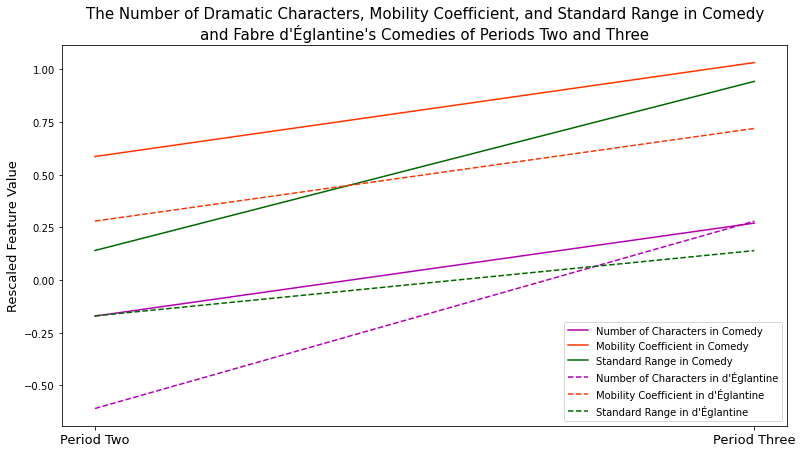

In [84]:
plt.figure(figsize=(13, 7))
plt.title('The Number of Dramatic Characters, Mobility Coefficient, and Standard Range in Comedy\n'\
             'and Fabre d\'Églantine\'s Comedies of Periods Two and Three',
         fontsize=15)
plt.plot(comedy['num_present_characters'], 
         label='Number of Characters in Comedy', 
         color = '#b300b3', linestyle='solid')
plt.plot(comedy['mobility_coefficient'], label='Mobility Coefficient in Comedy',
         color = '#ff3300', linestyle='solid')
plt.plot(comedy['standard_range'], label='Standard Range in Comedy',
         color='#006600', linestyle='solid')


plt.plot(fabre_df['num_present_characters'], 
         label='Number of Characters in d\'Églantine', 
         color = '#b300b3', linestyle='dashed')
plt.plot(fabre_df['mobility_coefficient'], label='Mobility Coefficient in d\'Églantine',
         color = '#ff3300', linestyle='dashed')
plt.plot(fabre_df['standard_range'], label='Standard Range in d\'Églantine',
         color='#006600', linestyle='dashed')


plt.xticks(fontsize=13)
plt.ylabel('Rescaled Feature Value', fontsize=13)
plt.legend()
plt.show()

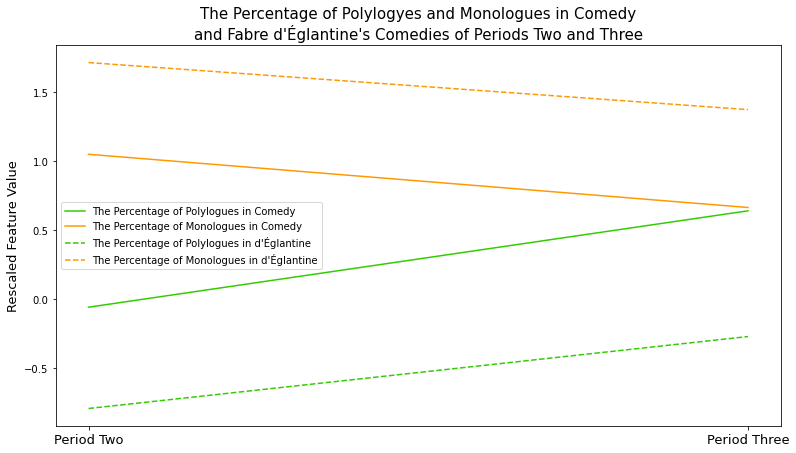

In [85]:
plt.figure(figsize=(13, 7))
plt.title('The Percentage of Polylogyes and Monologues in Comedy\n'\
             'and Fabre d\'Églantine\'s Comedies of Periods Two and Three',
         fontsize=15)
plt.plot(comedy['percentage_polylogues'],
         label='The Percentage of Polylogues in Comedy',
         color = '#33cc00', linestyle='solid')
plt.plot(comedy['percentage_monologues'], 
         label='The Percentage of Monologues in Comedy',
         color='#ff9900', linestyle='solid')
plt.plot(fabre_df['percentage_polylogues'],
         label='The Percentage of Polylogues in d\'Églantine',
         color = '#33cc00', linestyle='dashed')
plt.plot(fabre_df['percentage_monologues'], 
         label='The Percentage of Monologues in d\'Églantine',
         color='#ff9900', linestyle='dashed')

plt.xticks(fontsize=13)
plt.ylabel('Rescaled Feature Value', fontsize=13)
plt.legend()
plt.show()

### Collin d’Harleville 

In [86]:
print('Number dramatic characters in period two:',  
      round(period_two[period_two.last_name=='Collin d’Harleville']['num_present_characters'].mean(), 2))
print('Number dramatic characters in period three:', 
      period_three[period_three.last_name=='Collin d’Harleville']['num_present_characters'].mean())

Number dramatic characters in period two: 10.67
Number dramatic characters in period three: 11.0


In [87]:
print('Mobility coefficient in period two:',
      round(period_two[period_two.last_name=='Collin d’Harleville']['mobility_coefficient'].mean(), 2))
print('Mobility coefficient in period three:', 
      period_three[period_three.last_name=='Collin d’Harleville']['mobility_coefficient'].mean())

Mobility coefficient in period two: 60.33
Mobility coefficient in period three: 58.5


In [88]:
print('Standard range of the number of speaking characters in period two:', 
      period_two[period_two.last_name=='Collin d’Harleville'].pipe(speech_distribution_by_period).pipe(sigma_iarkho))
print('Standard range of the number of speaking characters in period three:',
       period_three[period_three.last_name=='Collin d’Harleville'].pipe(speech_distribution_by_period).pipe(sigma_iarkho))

Standard range of the number of speaking characters in period two: 1.07
Standard range of the number of speaking characters in period three: 1.24


In [89]:
print('The percentage of polylogues in period two:', 
     round(period_two[period_two.last_name=='Collin d’Harleville']['percentage_polylogues'].mean(), 2))
print('The percentage of polylogues in period three:',
     round(period_three[period_three.last_name=='Collin d’Harleville']['percentage_polylogues'].mean(), 2))

The percentage of polylogues in period two: 36.26
The percentage of polylogues in period three: 43.22


In [90]:
print('The percentage of monologues in period two:',
     round(period_two[period_two.last_name=='Collin d’Harleville']['percentage_monologues'].mean(), 2))
print('The percentage of monologues in period three:',
     round(period_three[period_three.last_name=='Collin d’Harleville']['percentage_monologues'].mean(), 2))

The percentage of monologues in period two: 18.99
The percentage of monologues in period three: 16.18


In [91]:
harleville_df = prepare_writer(period_two, period_three, 'Collin d’Harleville', [1.07, 1.24])

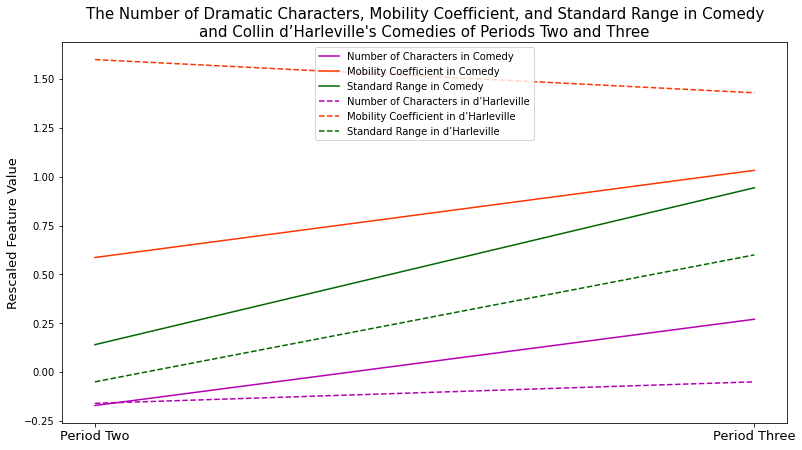

In [92]:
plt.figure(figsize=(13, 7))
plt.title('The Number of Dramatic Characters, Mobility Coefficient, and Standard Range in Comedy\n'\
             'and Collin d’Harleville\'s Comedies of Periods Two and Three',
         fontsize=15)
plt.plot(comedy['num_present_characters'], 
         label='Number of Characters in Comedy', 
         color = '#b300b3', linestyle='solid')
plt.plot(comedy['mobility_coefficient'], label='Mobility Coefficient in Comedy',
         color = '#ff3300', linestyle='solid')
plt.plot(comedy['standard_range'], label='Standard Range in Comedy',
         color='#006600', linestyle='solid')


plt.plot(harleville_df['num_present_characters'], 
         label='Number of Characters in d’Harleville', 
         color = '#b300b3', linestyle='dashed')
plt.plot(harleville_df['mobility_coefficient'], label='Mobility Coefficient in d’Harleville',
         color = '#ff3300', linestyle='dashed')
plt.plot(harleville_df['standard_range'], label='Standard Range in d’Harleville',
         color='#006600', linestyle='dashed')


plt.xticks(fontsize=13)
plt.ylabel('Rescaled Feature Value', fontsize=13)
plt.legend()
plt.show()

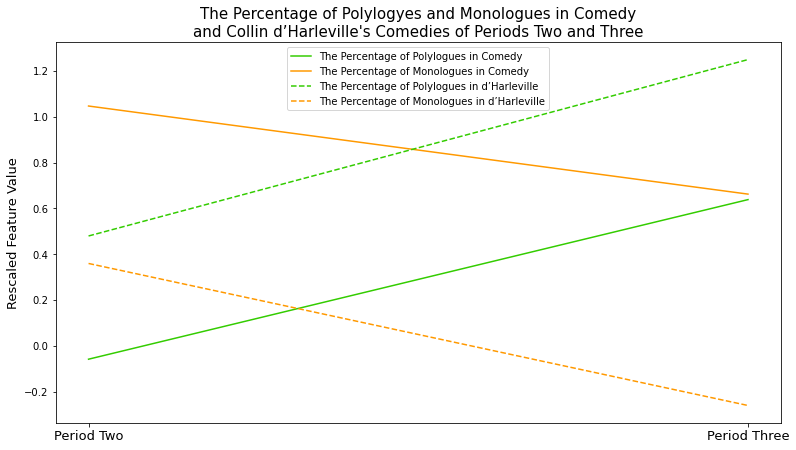

In [93]:
plt.figure(figsize=(13, 7))
plt.title('The Percentage of Polylogyes and Monologues in Comedy\n'\
             'and Collin d’Harleville\'s Comedies of Periods Two and Three',
         fontsize=15)
plt.plot(comedy['percentage_polylogues'],
         label='The Percentage of Polylogues in Comedy',
         color = '#33cc00', linestyle='solid')
plt.plot(comedy['percentage_monologues'], 
         label='The Percentage of Monologues in Comedy',
         color='#ff9900', linestyle='solid')
plt.plot(harleville_df['percentage_polylogues'],
         label='The Percentage of Polylogues in d’Harleville',
         color = '#33cc00', linestyle='dashed')
plt.plot(harleville_df['percentage_monologues'], 
         label='The Percentage of Monologues in d’Harleville',
         color='#ff9900', linestyle='dashed')

plt.xticks(fontsize=13)
plt.ylabel('Rescaled Feature Value', fontsize=13)
plt.legend()
plt.show()

Two playwrights,  Fabre d’Églantine and Jean-François Collin d’Harleville, produced comedies that spanned two periods -  two and three. Fabre d’Églantine was among the comedians who preferred closed forms (his open form score was -0.49), whereas Jean-François Collin d’Harleville wrote in a more open style (hist score was 0.17). What is fascinating is that their evolution reflected wider literary trends. From period two to period three, the number of dramatic characters increased from 10.64 to 11.96. The mean number of dramatic characters in Fabre d’Églantine's comedies increased from 9.33 in period two to 12 in period three, in Collin d’Harleville’s comedies - from 10.67 to 11. The standard range of the number of speaking characters rose from 1.12 in period two to 1.33 in period three. The standard range in Fabre d’Églantine's comedies progressed from 1.04 to 1.12,   in Collin d’Harleville’s comedies  - from 1.07 to 1.24.  The percentage of polylogues rose from 31.37 in period two to 37.69 in period three. The percentage of polylogues in Fabre d'Églantine's comedies increased from 24.71 to 29.41,  in Collin d’Harleville - from 36.26 to 43.22.  The percentage of monologues decreases from 22.08 in period two to 20.35 in period three. The percentage of monologues in Fabre d'Églantine's comedies decreased from 25.06 to 23,53, in Collin d’Harleville's comedies, it decreased from 18.99 to 16.18.  The mobility coefficient increased from 49.56 in period two to 54.31 in period three. Fabre d’Églantine's mobility coefficient increased from 46.33 in period two to 51 in period three. Collin d’Harleville's comedies, however, had a higher mobility coefficient in period two (60.33) than in period three (58.5), but in both cases, he was above the mean mobility coefficient of the period.

In [94]:
print('Number of playwrigthts writing comedies with the open form:', 
results[results.open_form_score >=0].shape[0])

Number of playwrigthts writing comedies with the open form: 61


In [95]:
print('Number of playwrigthts writing comedies with the closed form:', 
results[results.open_form_score  < 0].shape[0])

Number of playwrigthts writing comedies with the closed form: 60


## Conclusions:

1. For each feature and each period, we identified the comedies that represent the maxim and the minimum as well as such comedies that are the closest to the mean.
2. We discovered that there are at least nine comedies without monologues (all in period one).
3. Three authors (Chalussay, Rousseau, and Gosse) wrote the comedies that represent the maximum for their period based on at least two features.
4. Two authors (Pierre Corneille and Casimir Bonjour) wrote comedies that represent their period minimum based on at least two features.
5. We calculated **"open-form" scores** that capture how experimental each playwright in the context of the entire history of the French five-act comedy in verse. The preference for open form comedies throughout three periods can be described by the following percentages: 71.28%, 53.33%, and 86.67% in the prolific group, and  54.55%, 19.44%, 54.55% in the less prolific group. There was a drop in the second period, however, it was more extreme in the less prolific group (19.44% vs. 53.33% in the prolific). Additionally, during the first and third periods, both groups preferred open form comedies, but the magnitude of this preference was higher in the prolific group (71.28% vs. 54.55%  in the less prolific group during period one, and especially large difference (86.67% vs. 54.55% vs. in the less prolific group during period three).
6. We analyzed Fabre d'Églantine and Jean-François Collin d’Harleville's styles as they evolved over two periods and echoed wider literary trends. 